In [115]:
import requests as r

In [116]:
url ="https://api.covid19api.com/dayone/country/brazil"

In [117]:
resp = r.get(url)
print(resp.status_code)

200


In [118]:
raw_data = resp.json()
print(raw_data[0])

{'ID': '63aa488e-b4a2-4fcd-ae15-07c1ff219903', 'Country': 'Brazil', 'CountryCode': 'BR', 'Province': '', 'City': '', 'CityCode': '', 'Lat': '-14.24', 'Lon': '-51.93', 'Confirmed': 1, 'Deaths': 0, 'Recovered': 0, 'Active': 1, 'Date': '2020-02-26T00:00:00Z'}


In [119]:
final_data = []
for obs in raw_data:
    final_data.append([obs['Confirmed'], obs['Deaths'], obs['Recovered'], obs['Active'], obs['Date']])

print(final_data[0])

[1, 0, 0, 1, '2020-02-26T00:00:00Z']


In [120]:
final_data.insert(0, ['Confirmados', 'Obitos', 'Recuperados', 'Ativos', 'Data'])
print(final_data[0])

['Confirmados', 'Obitos', 'Recuperados', 'Ativos', 'Data']


In [121]:
#guardando os indices em variaveis para um acesso fácil de entender
confirmados=0
obitos=1
recuperados=2
ativos=3
data=4

for i in range(1, len(final_data)):
    final_data[i][data] = final_data[i][data][:10]

print(final_data[1])

[1, 0, 0, 1, '2020-02-26']


In [122]:
import datetime as dt

In [123]:
import csv

with open('brasil_covid.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerows(final_data)
#Testando para ver se salvou certo
with open('brasil_covid.csv', 'r') as file:
    dados = file.read()

In [124]:
#convertendo a data de string para objetos datetime
for i in range(1, len(final_data)):
    final_data[i][data] = dt.datetime.strptime(final_data[i][data], '%Y-%m-%d')
   

In [125]:
print(final_data[2])

[1, 0, 0, 1, datetime.datetime(2020, 2, 27, 0, 0)]


In [126]:
# criar funcoes para facilitar a manipulação de dados e passar para a api quickchart
#funcoes helpers
def get_datasets(y, labels): 
    if type(y[0])==list: # se o tipo de y for uma lista de listas então cada lista de y tem um valor correspondente em labels
        datasets = []
        for i in range(len(y)): # percorrendo a lista de listas para gerar um dicionairo de valores do tipo f(x)=y
            datasets.append({
                'label':labels[i], # eixo x 
                'data' :y[i] # eixo y
            })
        return datasets
    else: #caso contrario retorna um dicionario com um item apenas
        return [{
            'label':labels[0],
            'data': y
        }]


In [127]:
#segunda funcao helper
# essa funcao serve para gerar o titulo conforme o padrao da api, o titulo deve ser um part {title, display}, um é
#title é string e display é boolean. De acordo com o valor de display  a api exibe ou não o titulo.
def set_title(title=''): #O valor de display aqui será decidido de acordo com o valor de titulo
    if title != '':
        display='true'
    else:
        display='false'
    
    return {
        'title':title,
        'display':display
    }

In [128]:
#funcao que criar o chart conforme o padrao da api
def create_chart(x, y, labels, kind='bar', title=''):
    datasets = get_datasets(y, labels)
    options = set_title(title)
    chart = {
        'type':kind,
        'data':{
            'labels':x,
            'datasets':datasets
        },
        'options':options
    }
    return chart

In [129]:
#funcao que faz a requisicao para a api e retorna o conteudo da resposta em binario
def get_api_chart(chart):
    url_base='https://quickchart.io/chart'
    resp=r.get(f'{url_base}?c={str(chart)}')
    return resp.content

In [130]:
#salvao para salvar a imagem em um arquivo
def save_image(path, content):
    with open(path, 'wb') as image:
        image.write(content)

In [131]:
#importar bibliotecas para exibir a imagem
from PIL import Image
from IPython.display import display

In [132]:
#função para mostrar a imagem na tela usando as bibliotecas importadas
def display_image(path):
    img_pil = Image.open(path)
    display(img_pil)

In [133]:
#criando as variáveis necessárias para gerar o gráfico eixo x, eixo y e labels
#eixos y
y_data_confirmados = []
for obs in final_data[1::10]:
    y_data_confirmados.append(obs[confirmados])
y_data_recuperados = []
for obs in final_data[1::10]:
    y_data_recuperados.append(obs[recuperados])

#labels
labels = ['Confirmados', 'Recuperados']

#eixo x

eixo_x = []
for obs in final_data[1::10]:
    eixo_x.append(obs[data].strftime('%d/%m/%Y'))





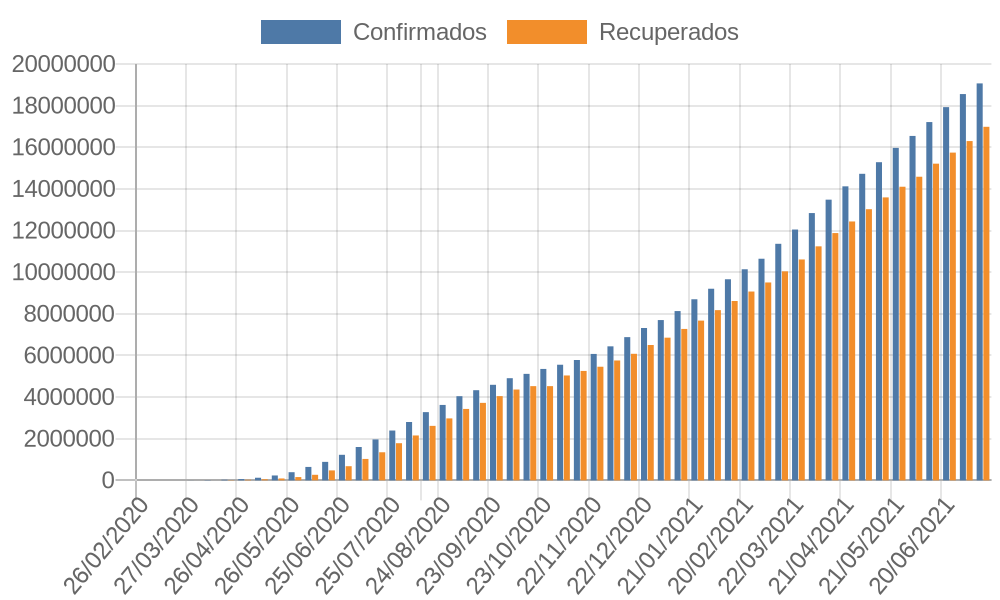

In [134]:
#gerando o grafico
#criando o chart 
chart = create_chart(eixo_x, [y_data_confirmados, y_data_recuperados], labels, title="Gráfico Confirmados vs Recuperados")

#fazendo a requisição para a api
chart_content = get_api_chart(chart)

#salvando a imagem num arquivo local
save_image('Grafico_confirmados_vs_recuperados.png', chart_content)

#exibindo o gráfico
display_image('Grafico_confirmados_vs_recuperados.png')

In [135]:
#biblioteca para fazero parsing do link
from urllib.parse import quote

In [136]:
#função para gerar o qrcode do link do gráfico gerado pela api
def get_api_qrcode(link):
    text = quote(link) #parsing do link para url
    url_base='https://quickchart.io/qr'
    resp=r.get(f'{url_base}?text={text}')
    return resp.content

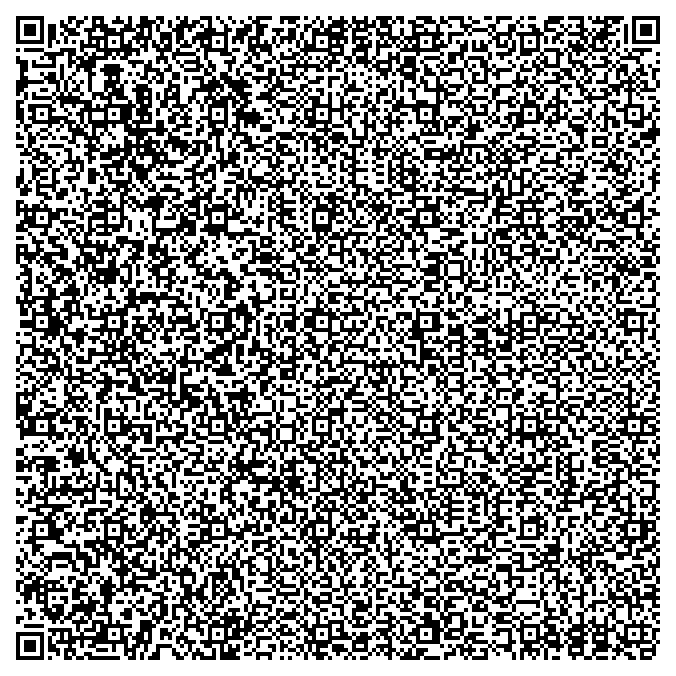

In [137]:
url_base='https://quickchart.io/chart'
link  = f'{url_base}?c={str(chart)}'
#salvando qrcode
save_image('qr-code.png', get_api_qrcode(link))
#exibindo o qrcode
display_image('qr-code.png')